In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [5]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_5')
labels_dir = Path(data_dir, 'labels_3')
models_dir = Path(Path.cwd().parent, 'models')
datasets_order = {
    'chains_eq_2': 0,
    'chains_eq_3': 1,
    'chains_ge_4_lt_10': 2,
    'chains_ge_10': 3}

datasets_names = {
    'chains_eq_2': r'CL $= 2$',
    'chains_eq_3': r'CL $= 3$',
    'chains_ge_4_lt_10': r'10 $>$ CL $\geq$ 4',
    'chains_ge_10': r'CL $\geq$ 10'}

sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size
    
score_names = [
    f'Worse{" "*12}Silhouette{" "*12}Better',
    f'Worse{" "*8}Calinski-Harabasz{" "*8}Better',
    f'Better{" "*10}Davies-Bouldin{" "*10}Worse',
    f'Stable{" "*16}Entropy{" "*16}Unstable'
]

In [6]:
df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)
df_kmeans['name'] = df_kmeans['dataset'].map(datasets_names)
df_kmeans = df_kmeans.sort_values('order')
df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
df_kmeans['method'] = 'KMeans'

df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)
df_dbscan['name'] = df_dbscan['dataset'].map(datasets_names)
df_dbscan = df_dbscan.sort_values('order')
df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_dbscan['method'] = 'DBSCAN'

df_hdbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')], ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)
df_hdbscan['name'] = df_hdbscan['dataset'].map(datasets_names)
df_hdbscan = df_hdbscan.sort_values('order')
df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_hdbscan['method'] = 'HDBSCAN'
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()

scores = ['sl_score', 'ch_score', 'db_score', 'entropy']

# KMeans

In [7]:
df_kmeans

,distance,dataset,n_clusters,sl_score,ch_score,db_score,entropy,dimensions,order,name,k_noise,method
27,euclidean,chains_eq_2,5,0.061043,354.822918,6.168124,1.272948,300,0,CL $= 2$,5,KMeans
26,euclidean,chains_eq_2,4,0.112543,347.211578,4.960518,0.936062,300,0,CL $= 2$,4,KMeans
25,euclidean,chains_eq_2,3,0.110616,519.343609,6.925530,0.998121,300,0,CL $= 2$,3,KMeans
24,euclidean,chains_eq_2,2,0.134493,796.314484,5.126896,0.683153,300,0,CL $= 2$,2,KMeans
8,euclidean,chains_eq_2,2,0.123197,966.626770,4.727751,0.672388,50,0,CL $= 2$,2,KMeans
9,euclidean,chains_eq_2,3,0.081789,695.439039,5.371419,1.019242,50,0,CL $= 2$,3,KMeans
10,euclidean,chains_eq_2,4,0.065737,600.649496,4.926190,1.249515,50,0,CL $= 2$,4,KMeans
11,euclidean,chains_eq_2,5,0.066393,520.701639,4.438305,1.324151,50,0,CL $= 2$,5,KMeans
15,euclidean,chains_eq_3,5,0.123916,63.366132,3.302113,0.686710,300,1,CL $= 3$,5,KMeans
29,euclidean,chains_eq_3,3,0.020602,184.837520,5.715278,1.079868,50,1,CL $= 3$,3,KMeans


In [16]:
iter_dataset = iter(df_kmeans.sort_values(by='order')['dataset'].unique())

chains_eq_2


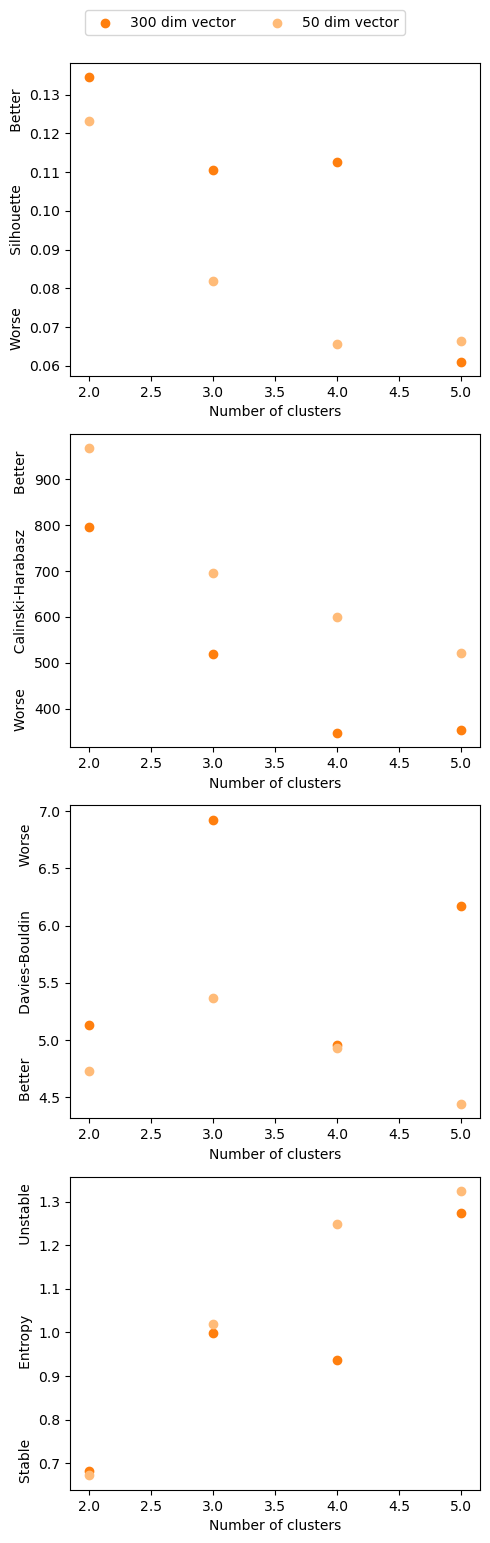

In [17]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=2)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


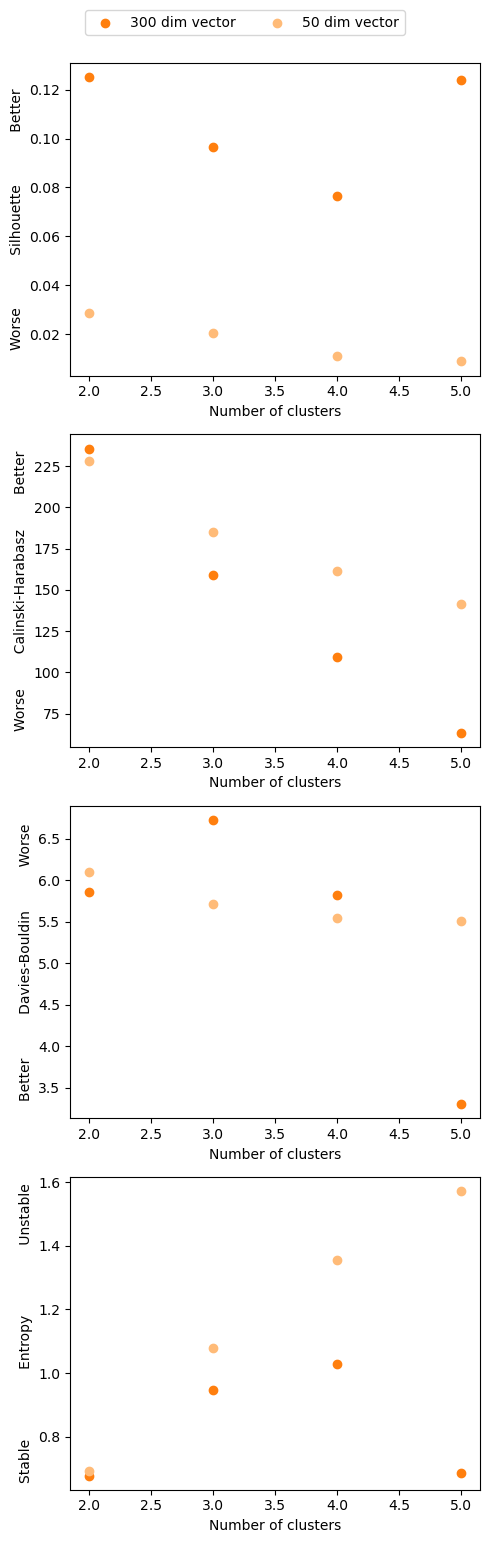

In [18]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


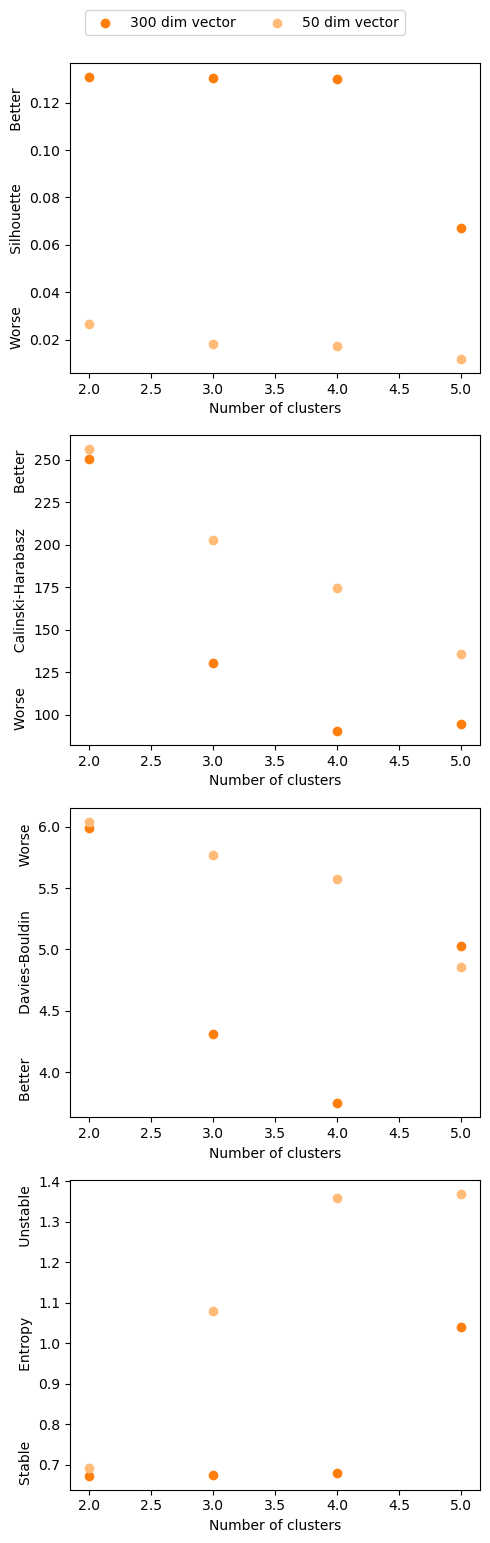

In [19]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


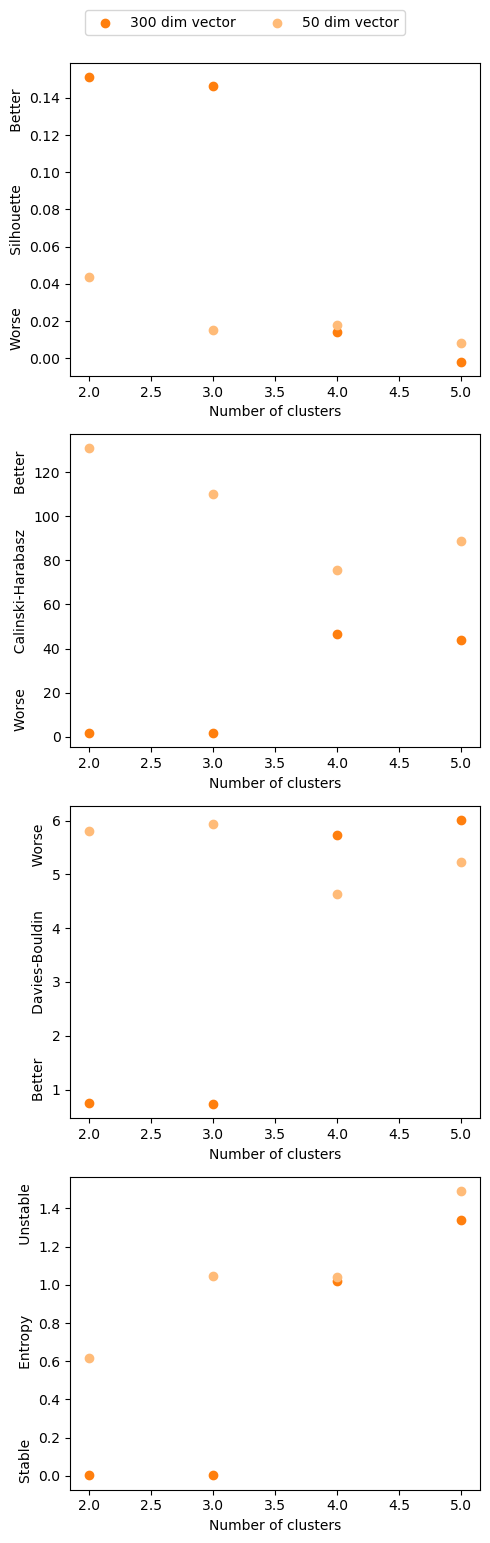

In [20]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

# DBSCAN 

In [21]:
df_dbscan

,distance,dataset,epsilon,min_pts,nn,n_clusters,sl_score,ch_score,db_score,entropy,n_noise,size,prop_noise,dimensions,order,name,k_noise,method
0,cosine,chains_eq_2,17.009451,2,2.0,1,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
4729,cosine,chains_eq_2,13.808106,13,20.0,1,NaN,NaN,NaN,NaN,NaN,23841,NaN,50,0,CL $= 2$,1 (nan),DBSCAN
4730,cosine,chains_eq_2,13.808106,14,20.0,1,NaN,NaN,NaN,NaN,NaN,23841,NaN,50,0,CL $= 2$,1 (nan),DBSCAN
4731,cosine,chains_eq_2,13.808106,15,20.0,1,NaN,NaN,NaN,NaN,NaN,23841,NaN,50,0,CL $= 2$,1 (nan),DBSCAN
4732,cosine,chains_eq_2,13.833861,2,21.0,1,NaN,NaN,NaN,NaN,NaN,23841,NaN,50,0,CL $= 2$,1 (nan),DBSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7584,cosine,chains_ge_10,5.401439,12,21.0,1,NaN,NaN,NaN,NaN,NaN,5324,NaN,300,3,CL $\geq$ 10,1 (nan),DBSCAN
7585,cosine,chains_ge_10,5.401439,13,21.0,1,NaN,NaN,NaN,NaN,NaN,5324,NaN,300,3,CL $\geq$ 10,1 (nan),DBSCAN
7586,cosine,chains_ge_10,5.401439,14,21.0,1,NaN,NaN,NaN,NaN,NaN,5324,NaN,300,3,CL $\geq$ 10,1 (nan),DBSCAN
7576,cosine,chains_ge_10,5.401439,4,21.0,1,NaN,NaN,NaN,NaN,NaN,5324,NaN,300,3,CL $\geq$ 10,1 (nan),DBSCAN


In [27]:
df_dbscan.loc[df_dbscan['distance'] == 'cosine', 'n_clusters'].counter

0       1
4729    1
4730    1
4731    1
4732    1
       ..
7584    1
7585    1
7586    1
7576    1
5887    1
Name: n_clusters, Length: 3248, dtype: int64

In [24]:
df_dbscan['distance'].unique()

array(['cosine', 'wmd', 'euclidean'], dtype=object)

In [22]:
iter_dataset = iter(df_dbscan.sort_values(by='order')['dataset'].unique())

chains_eq_2


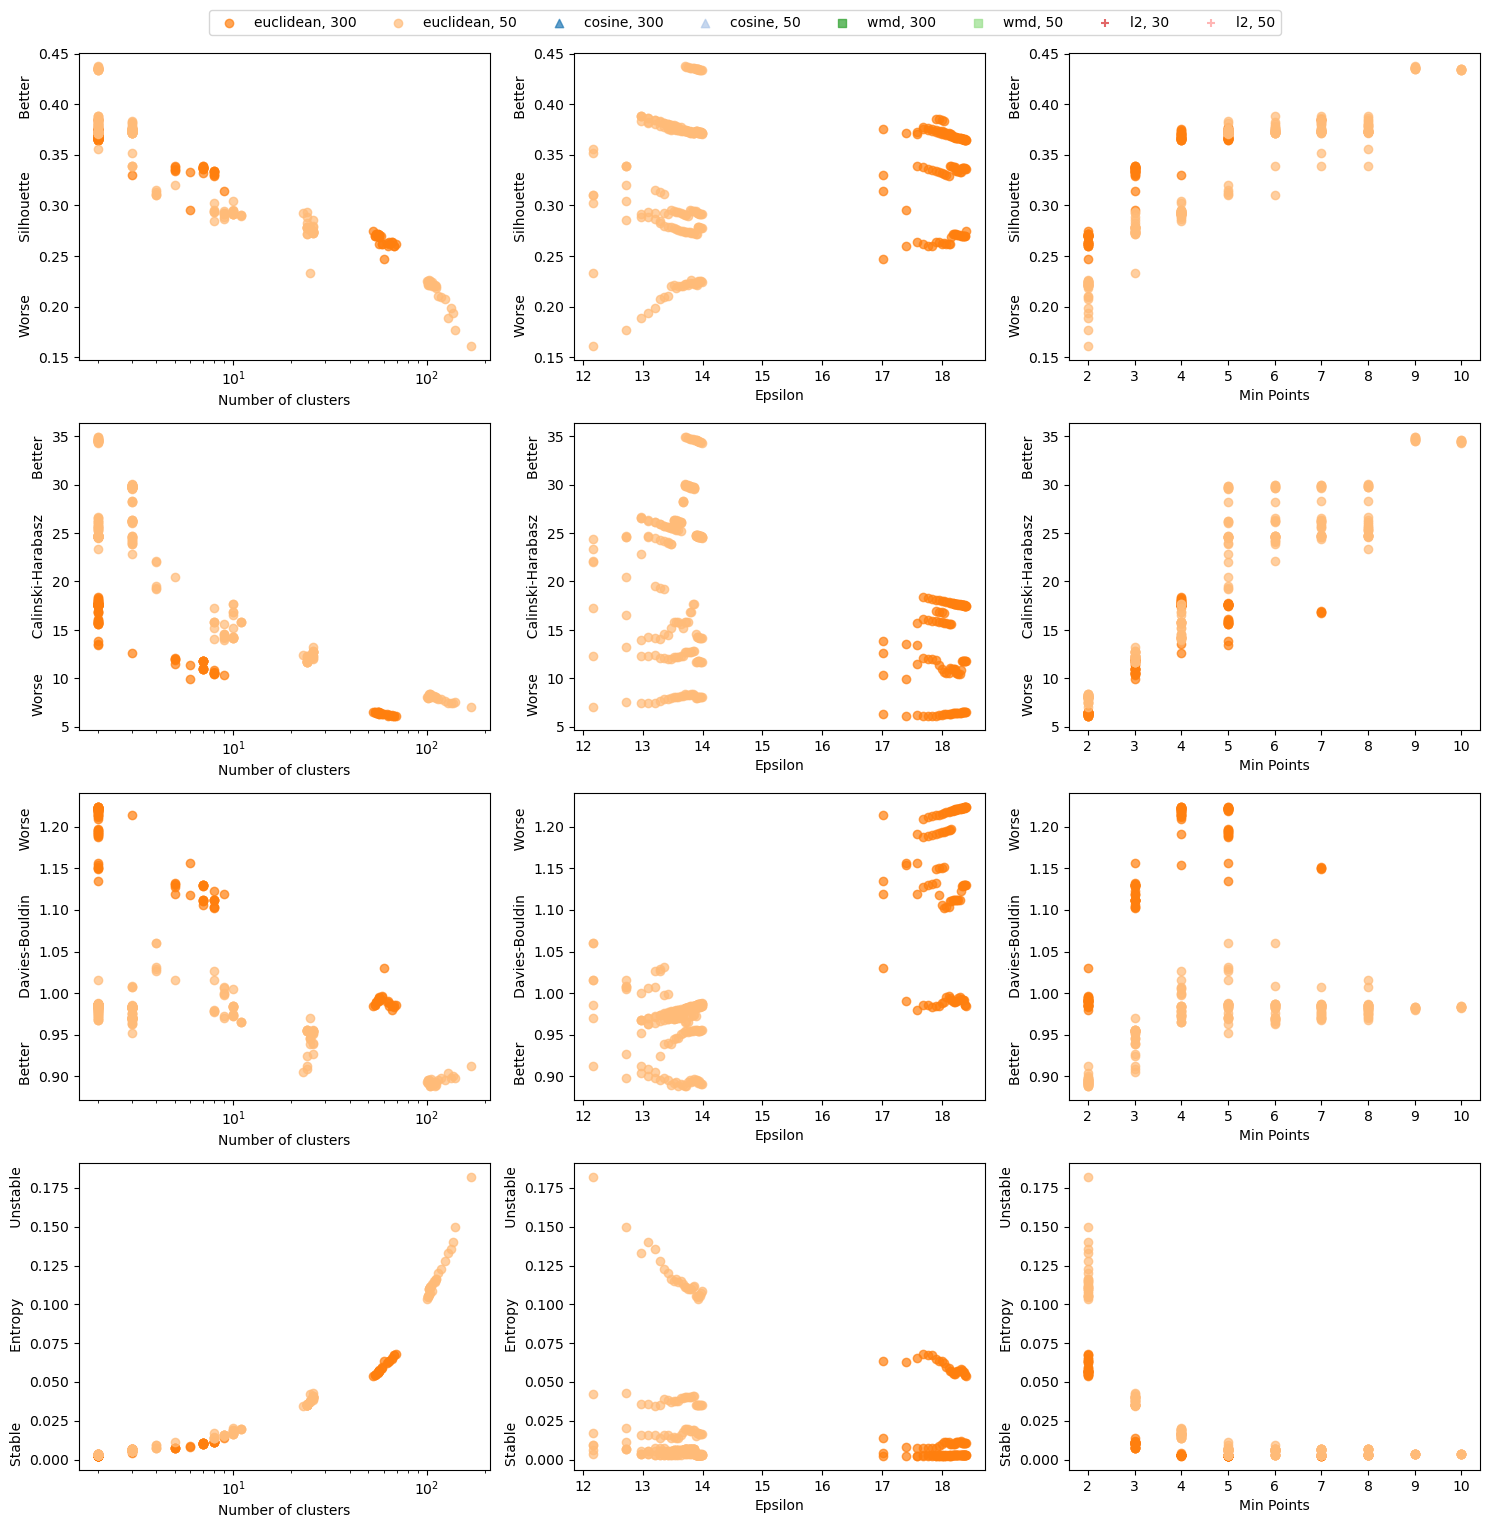

In [23]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_dbscan.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


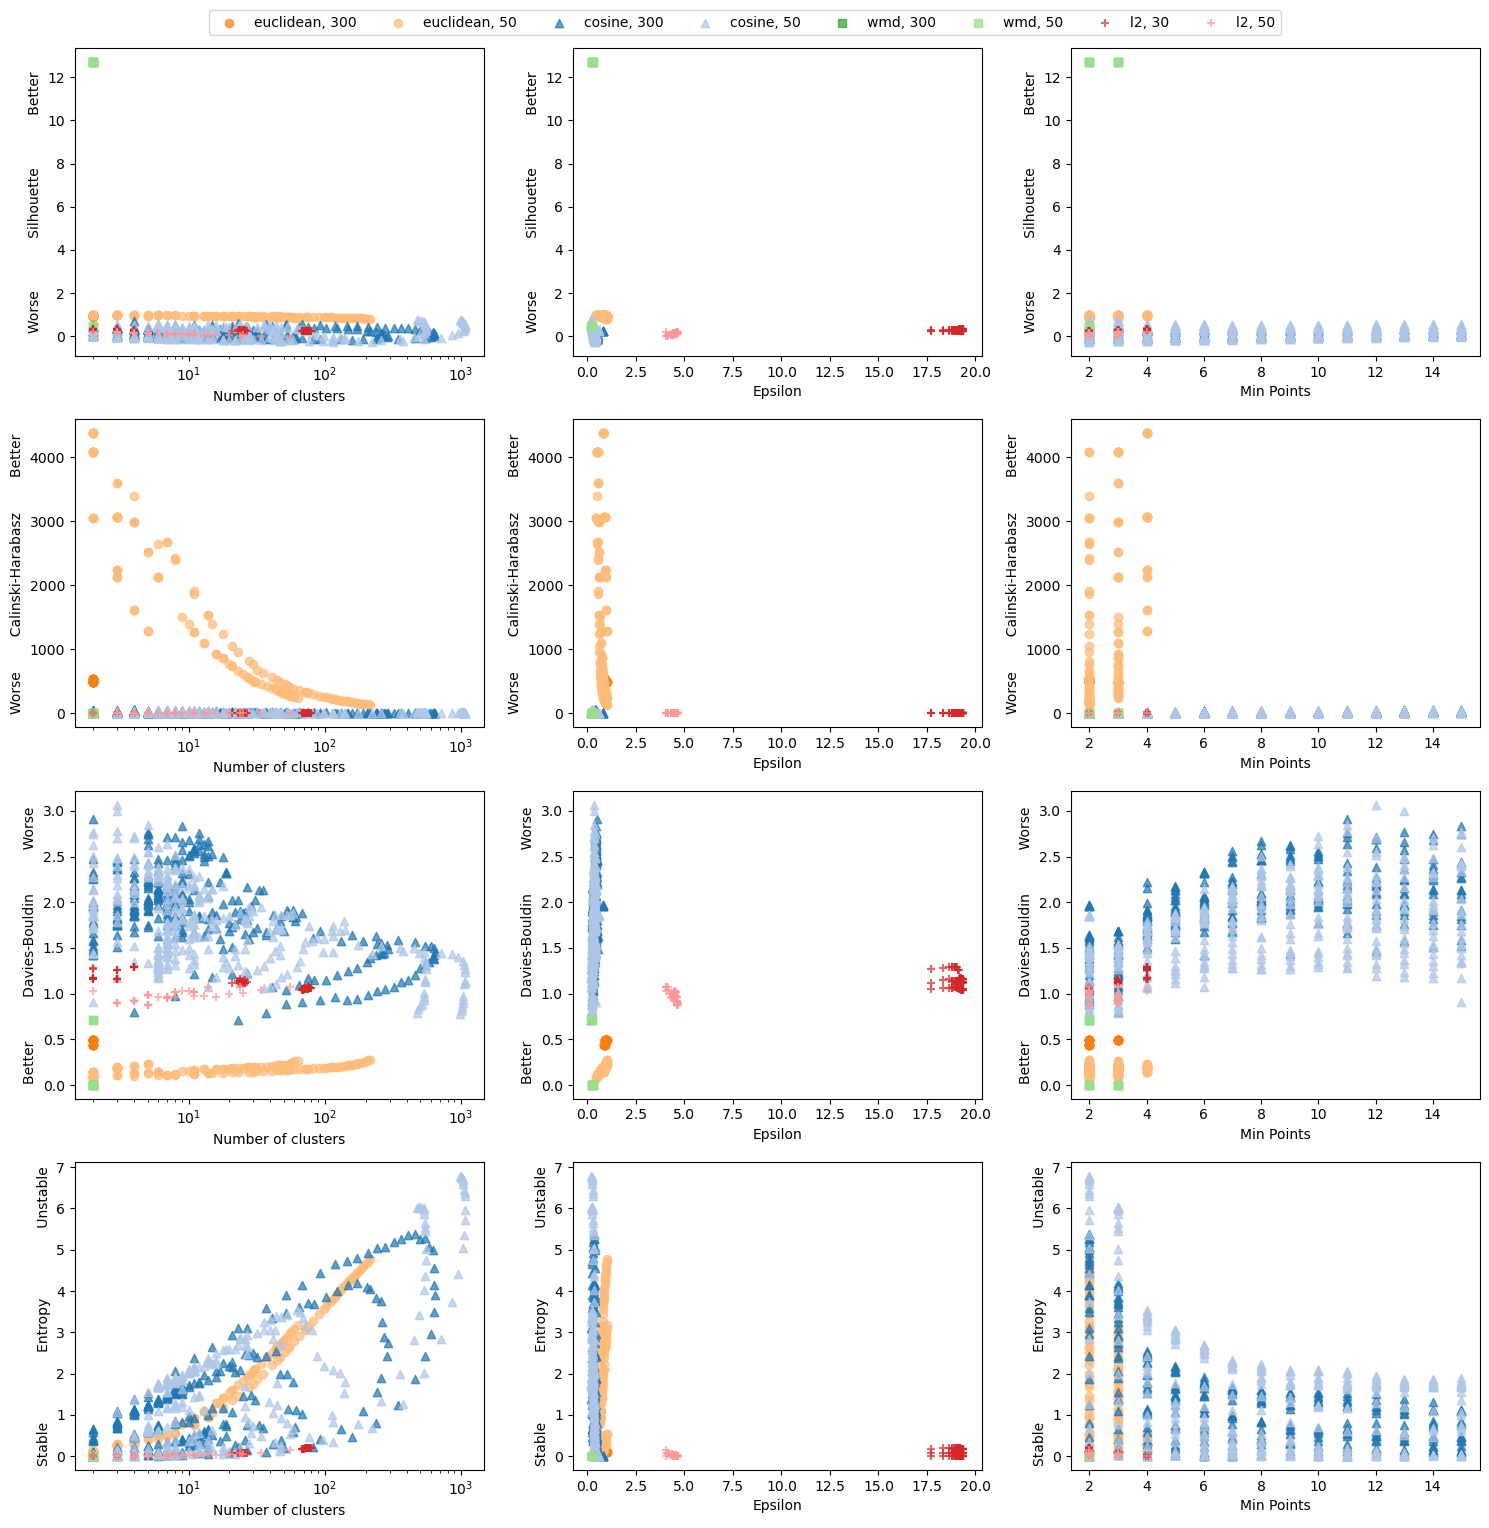

In [13]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


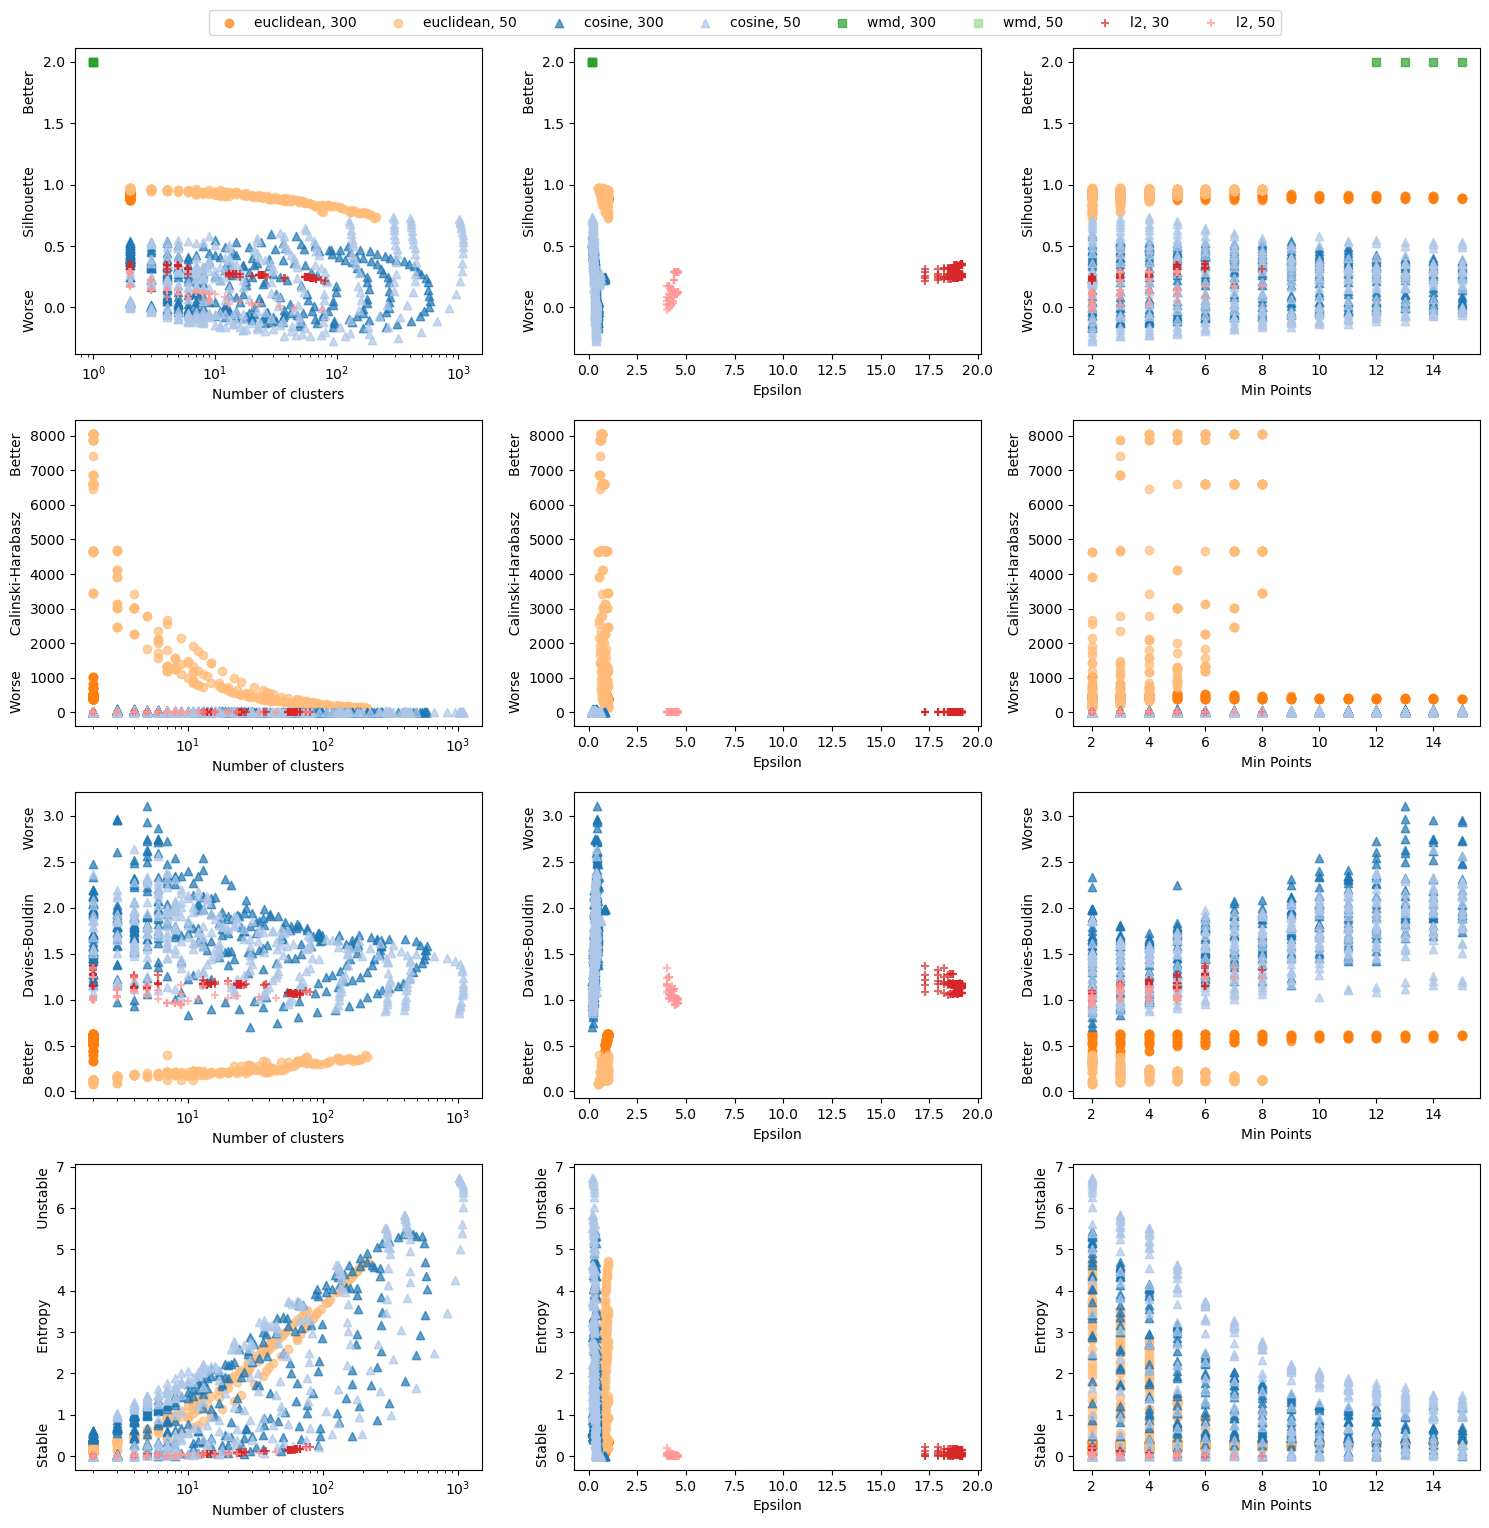

In [14]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


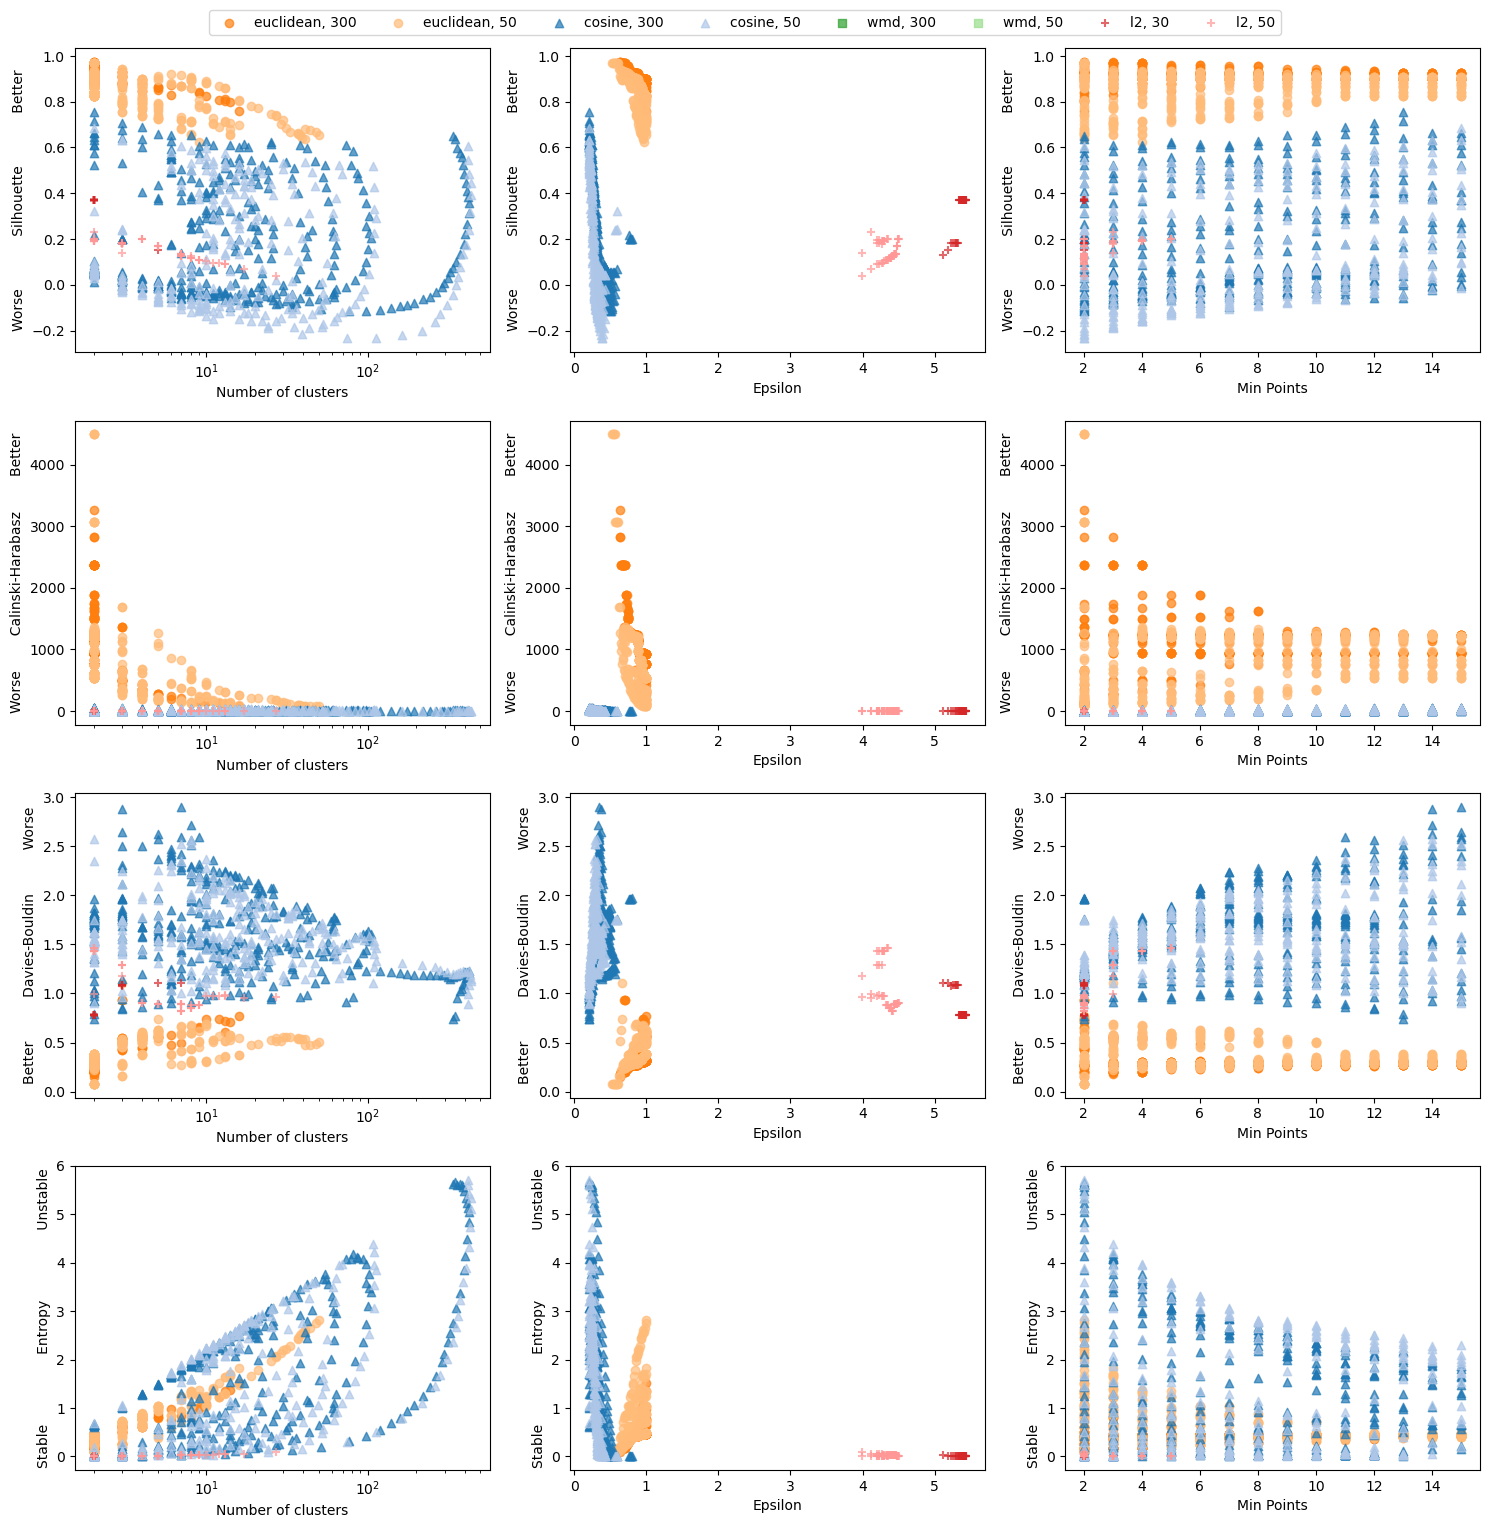

In [15]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

# HDBSCAN

In [16]:
df_hdbscan.sort_values(by='order')['dataset'].unique()

array(['chains_eq_3', 'chains_ge_4_lt_10', 'chains_ge_10'], dtype=object)

In [17]:
iter_dataset = iter(df_hdbscan.sort_values(by='order')['dataset'].unique())

chains_eq_3


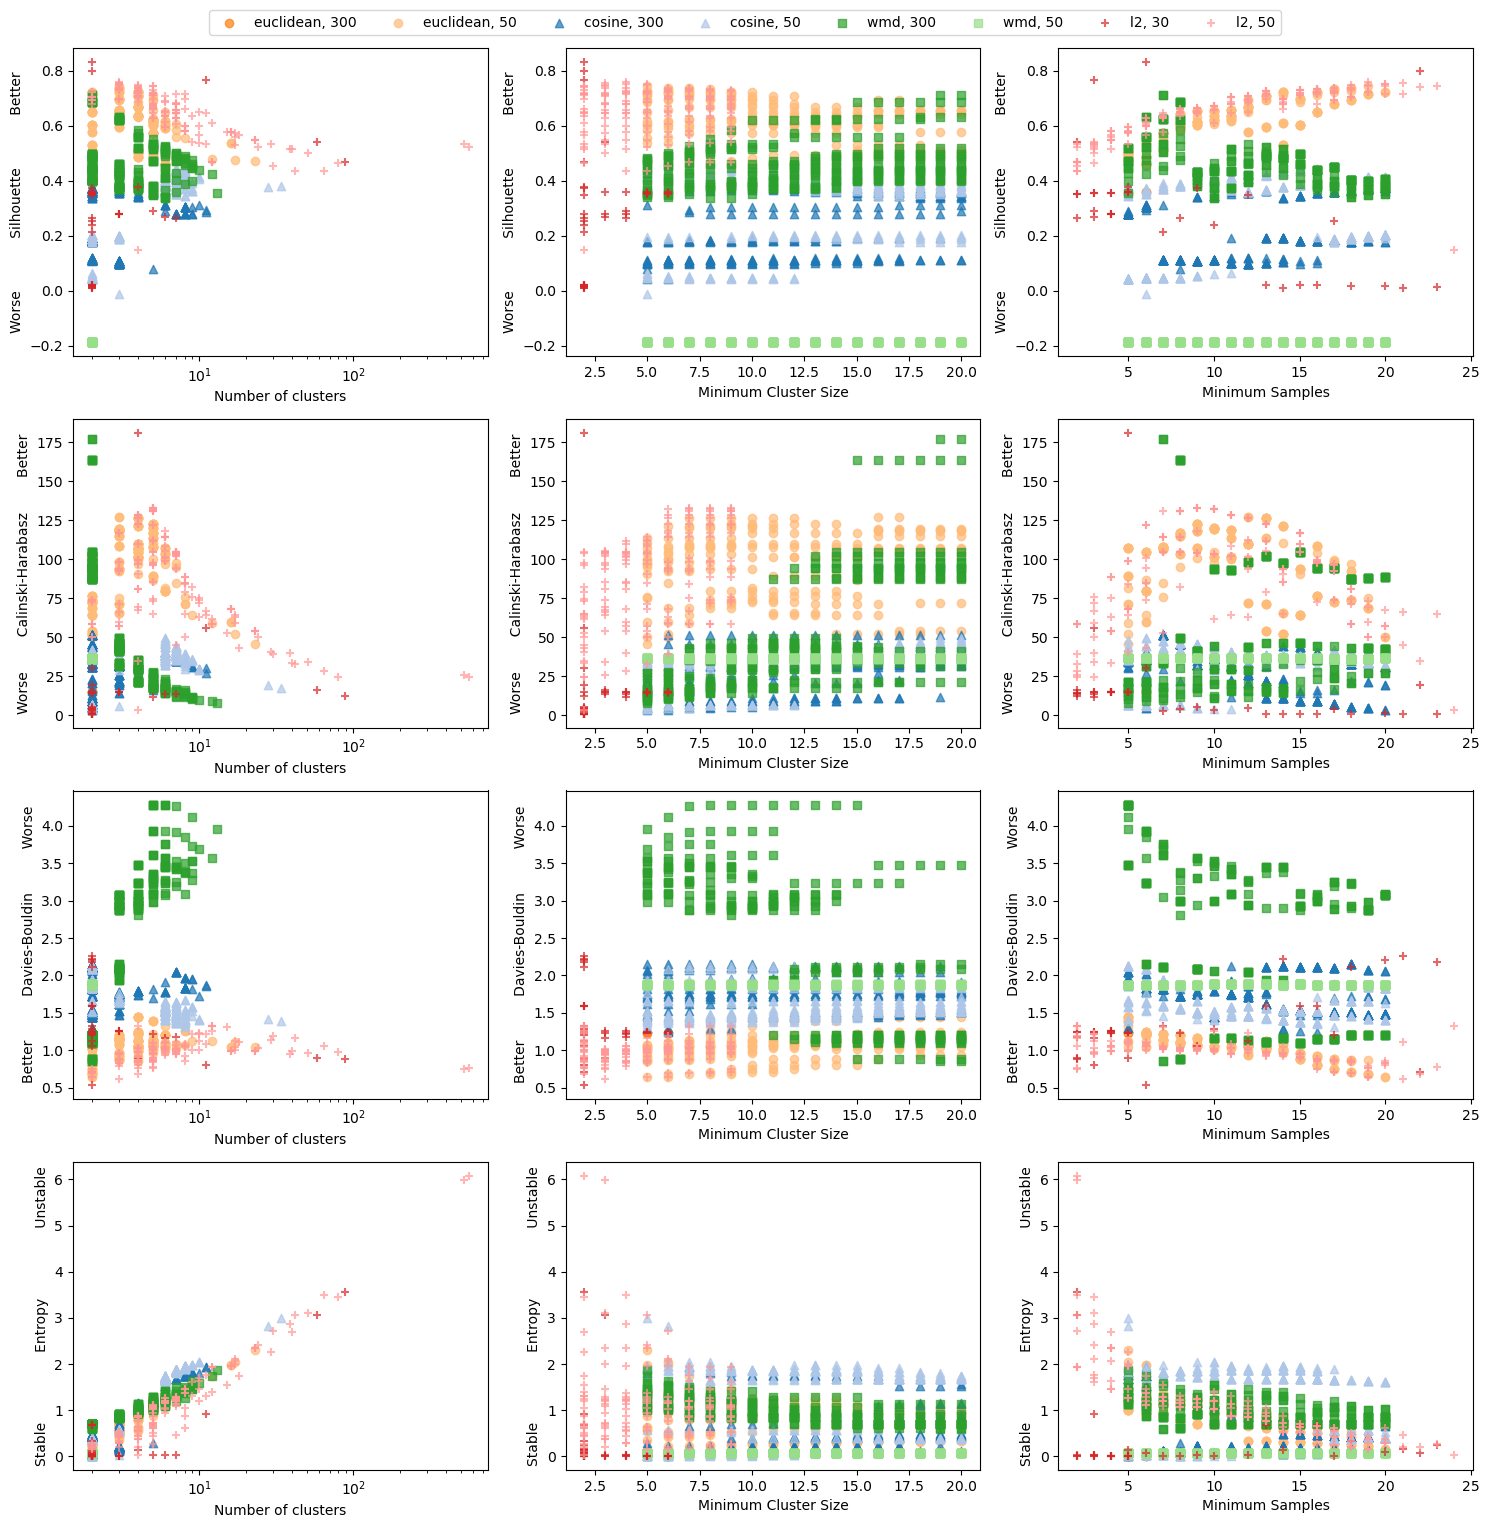

In [18]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


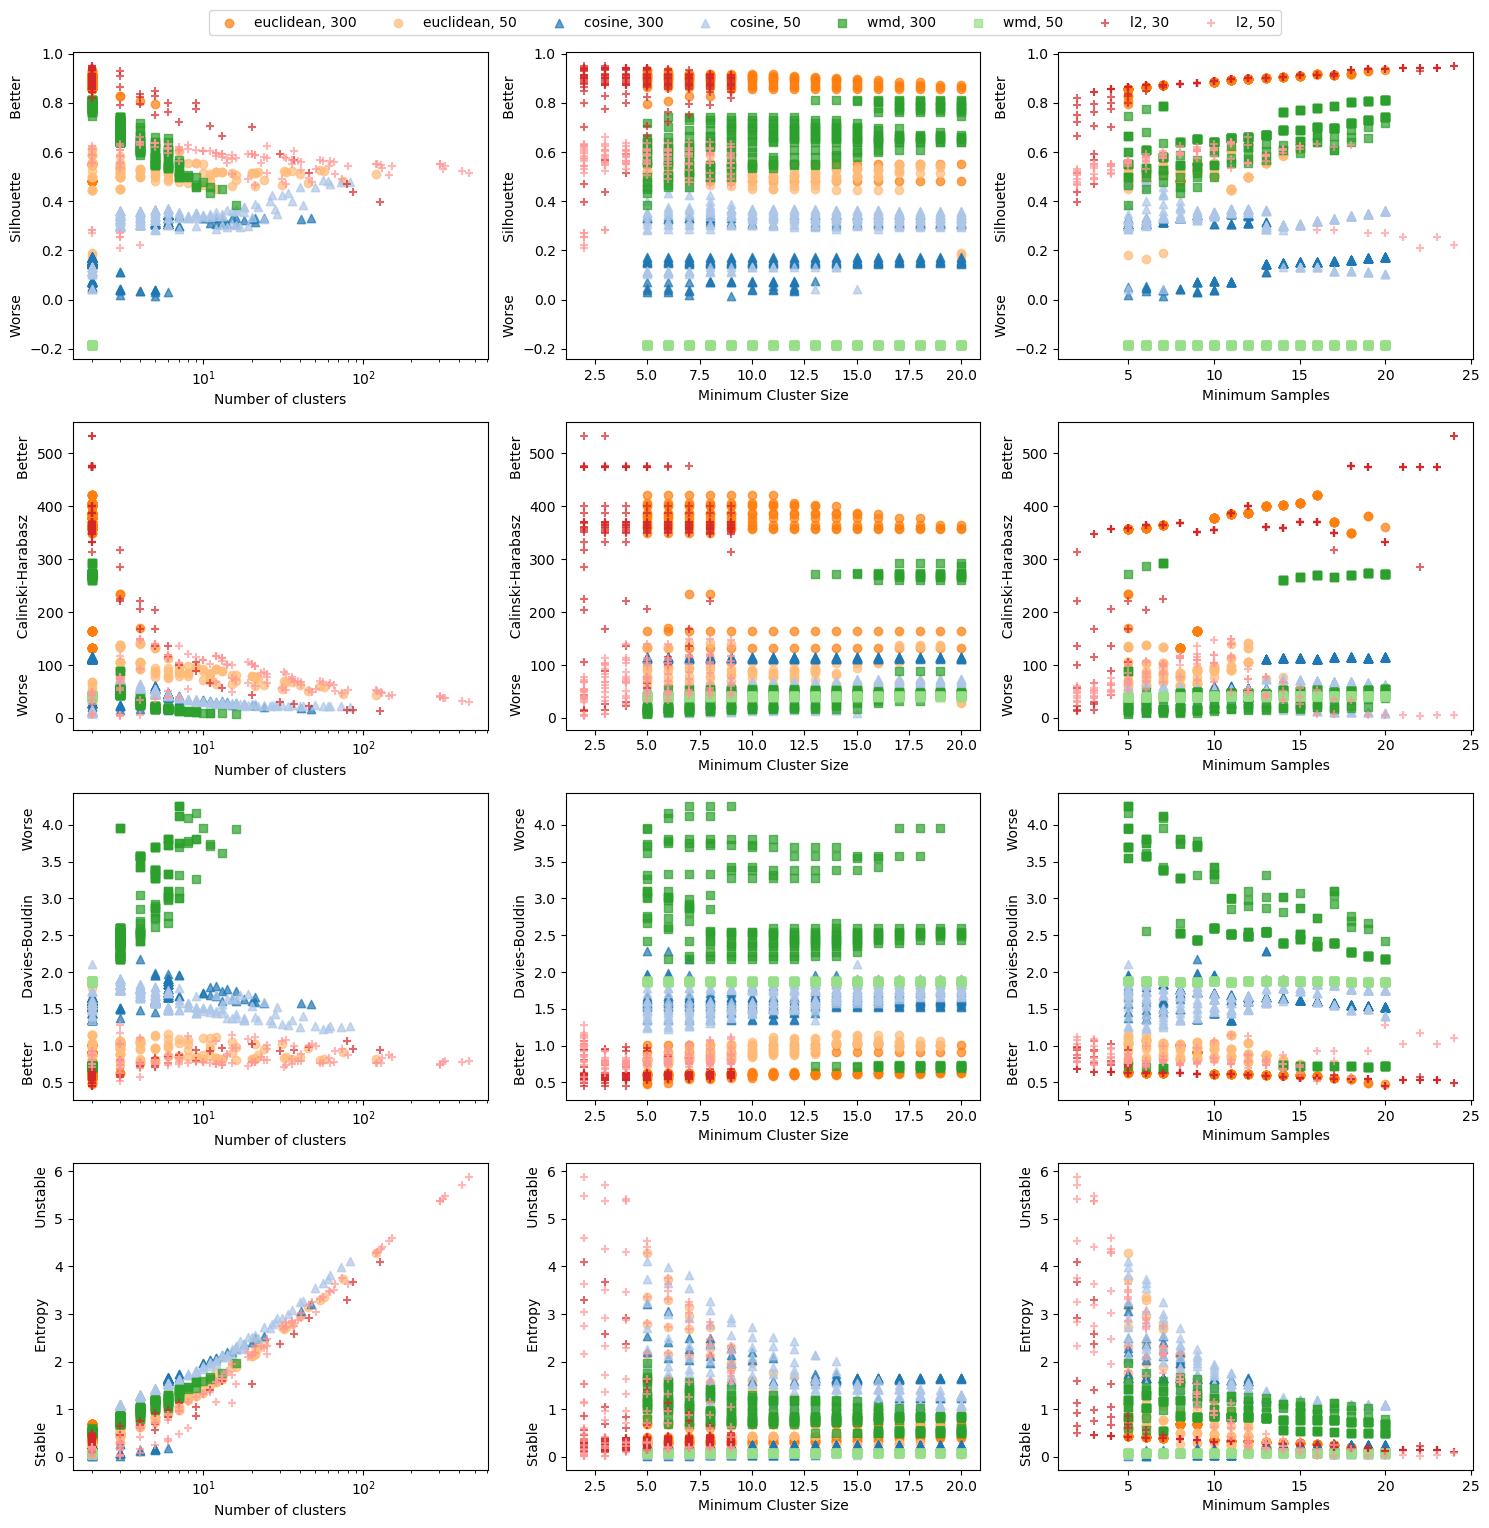

In [19]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


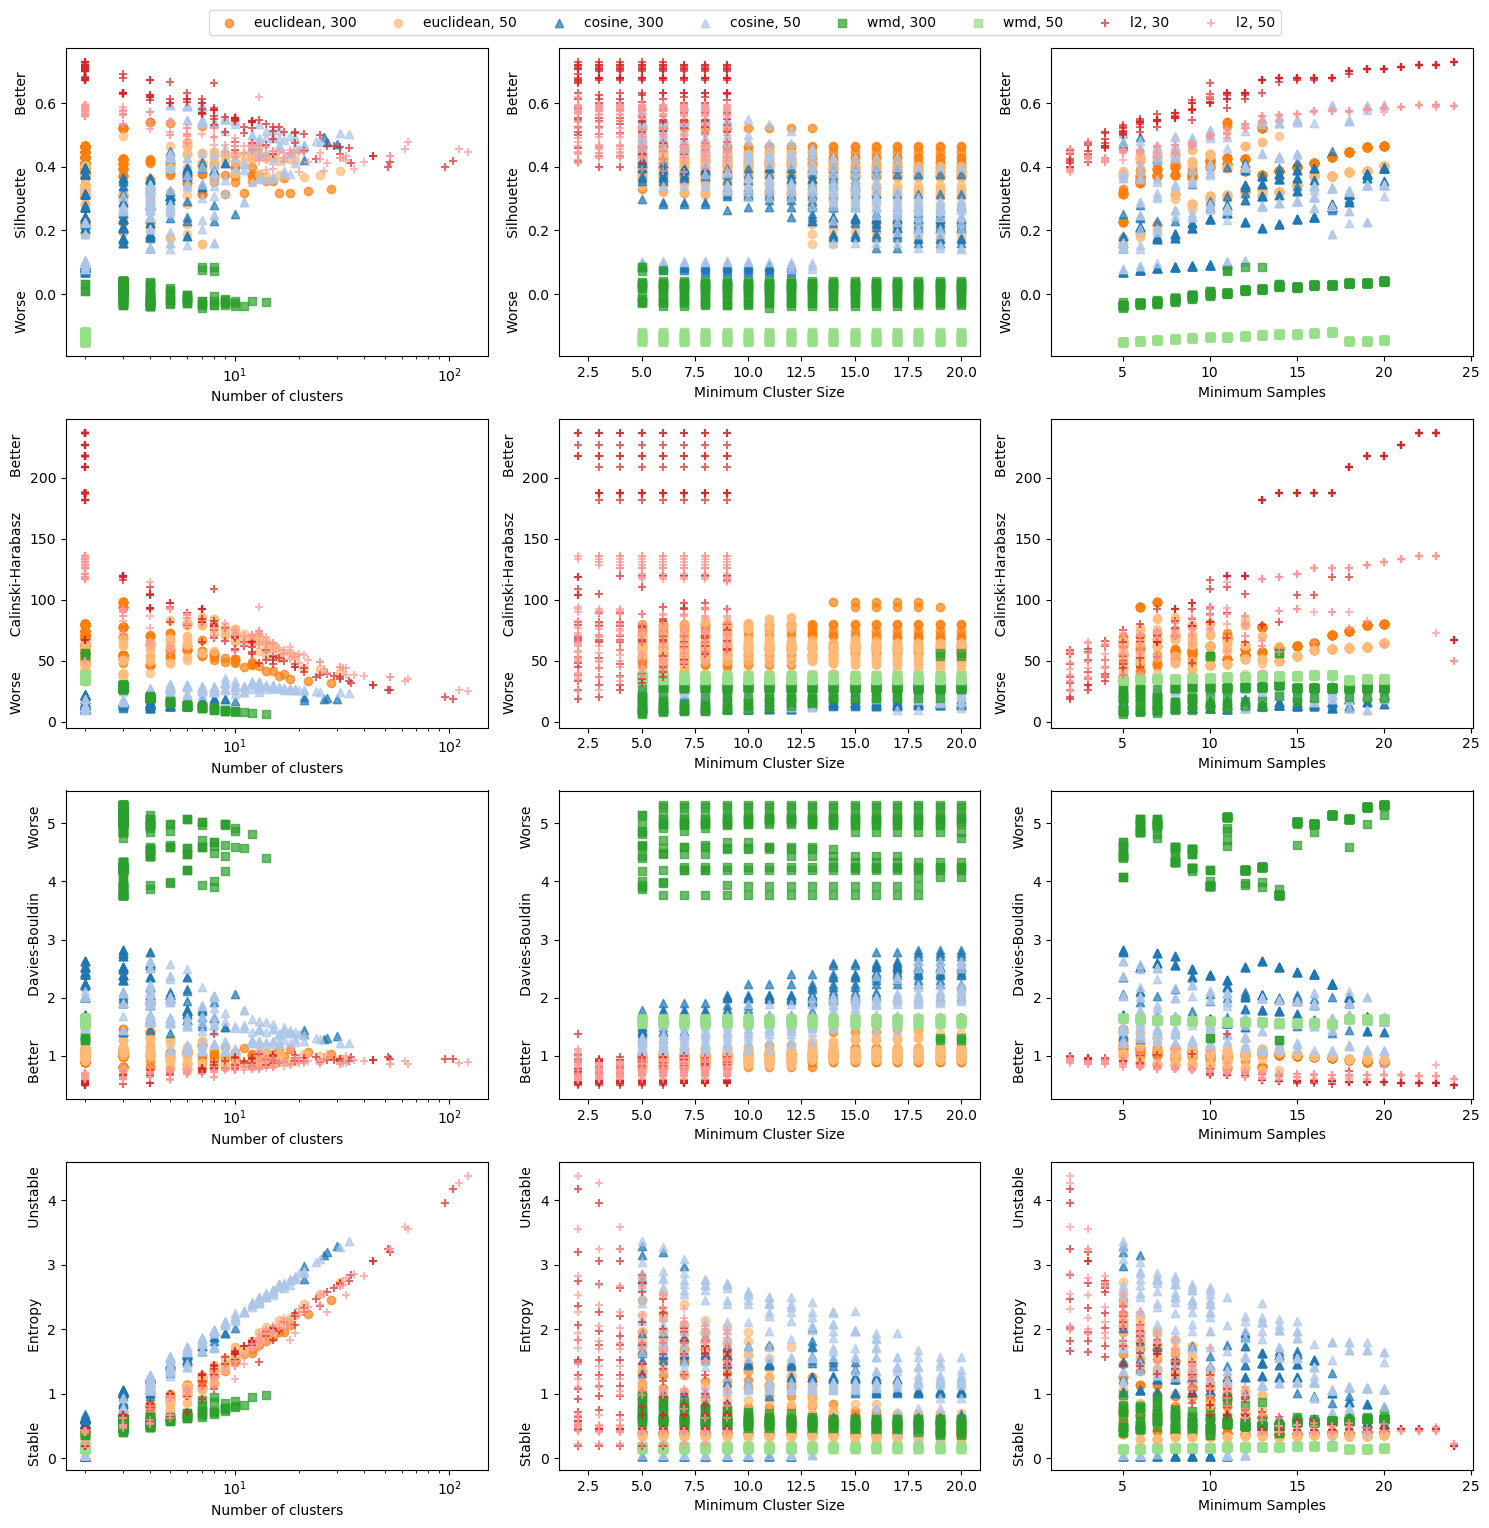

In [20]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()